In [148]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from experiments.rules_vs_exemplars.rules_exemplars import TwoDimensionalDataGen, classify_data

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process import kernels as gpk
from sklearn.base import clone

from tqdm.notebook import tqdm

In [149]:
cmap = "PiYG"
n_iter = 20
mlp_hidden_layer_sizes = (2,)

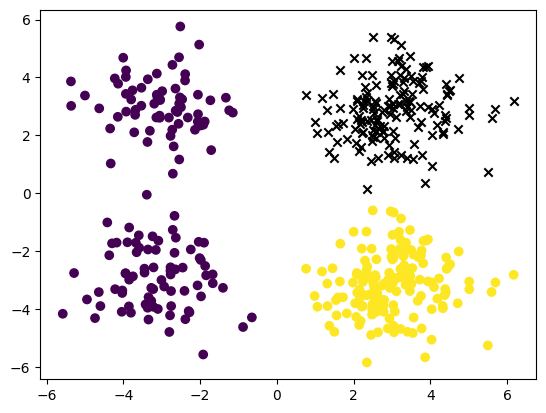

In [150]:
dataset = TwoDimensionalDataGen()
plt.scatter(*dataset.train_x.T, c=dataset.train_y)
plt.scatter(*dataset.test_x.T, c='k', marker='x')

In [151]:
x_train = dataset.train_x
y_train = dataset.train_y

# Create a mesh to plot in
x_min, x_max = dataset.train_x[:, 0].min() - 1, dataset.train_x[:, 0].max() + 1
y_min, y_max = dataset.train_x[:, 1].min() - 1, dataset.train_x[:, 1].max() + 1
h = 0.02  # step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))


In [152]:
# Create and train logistic regression model
model = LogisticRegression()
model.fit(dataset.train_x, dataset.train_y)

LogisticRegression()

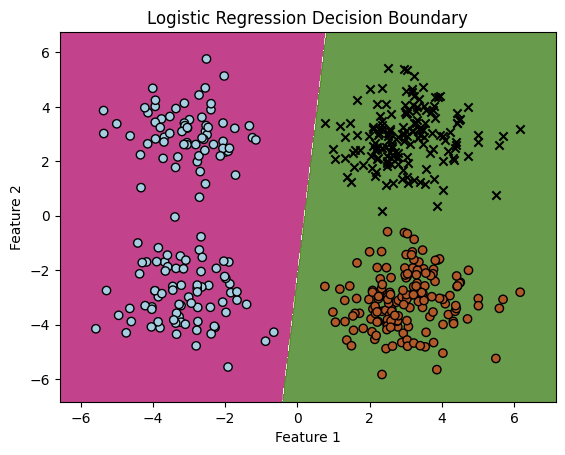

In [153]:


# Predict on each point in the mesh and plot
Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.8, cmap=cmap)

# Plot also the training points
plt.scatter(dataset.train_x[:, 0], dataset.train_x[:, 1], c=dataset.train_y, edgecolors='k', cmap=plt.cm.Paired)

# and the test points
plt.scatter(*dataset.test_x.T, c='k', marker='x')

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Logistic Regression Decision Boundary')
plt.show()


In [154]:
# Create and train MLP model

Z_mean = np.empty((xx.shape[0], xx.shape[1], n_iter))
for i in range(n_iter):
    mlp = MLPClassifier(hidden_layer_sizes=(5,), max_iter=1000)
    mlp.fit(x_train, y_train)

    # Predict on each point in the mesh and plot
    Z = mlp.predict(np.c_[xx.ravel(), yy.ravel()])
    Z_mean[:, :, i] = Z.reshape(xx.shape)

Z_mean = Z_mean.mean(axis=2)



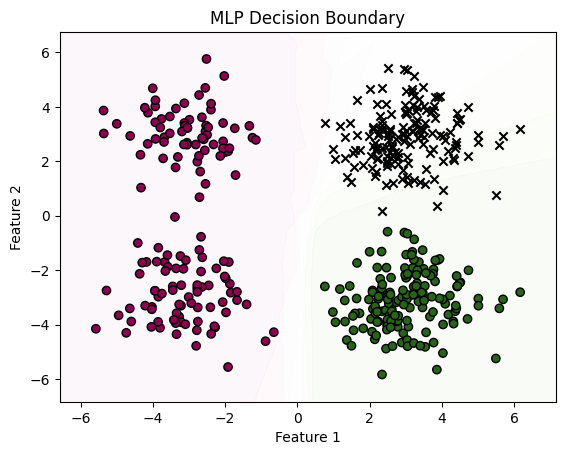

In [155]:
plt.contourf(xx, yy, Z_mean, alpha=.03, cmap=cmap)

#plt.contourf(xx, yy, Z_mean, alpha=.03, levels = [0.0, 0.5, 1.1], colors = ['#44AA99', '#AA4499', '#AA4499'])
# Plot also the training points
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train, edgecolors='k', cmap=cmap)
# and the test points
plt.scatter(*dataset.test_x.T, c='k', marker='x')

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('MLP Decision Boundary')
plt.show()


In [156]:
clfs = [
    (LogisticRegression(), 'logreg'),

    (GaussianProcessClassifier(kernel = gpk.RBF(), max_iter_predict = 20), 'gauss_kernel'),

    (MLPClassifier(hidden_layer_sizes = mlp_hidden_layer_sizes,
                                 activation = 'relu',
                                 max_iter=2000), 'MLP_{}H_1L'.format(mlp_hidden_layer_sizes[0]))
]

training_conditions = [
    (dataset.generate_data(pi_0=1, pi_1=0), 'CueConflict'),
    (dataset.generate_data(pi_0=0, pi_1=0), 'ZeroShot'),
    (dataset.generate_data(pi_0=0.5, pi_1=0), 'PartialExposure')
]

In [157]:
def get_decision_boundary(clf, x_train, y_train, xx, yy):
    clf.fit(x_train, y_train)
    pred = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    pred = pred.reshape(xx.shape)
    return pred, clf

trainingCondition:   0%|          | 0/3 [00:00<?, ?it/s]

Classifier:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration:   0%|          | 0/20 [00:00<?, ?it/s]

Classifier:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration:   0%|          | 0/20 [00:00<?, ?it/s]

/Users/jessegeerts/miniconda3/envs/torch/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


Classifier:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration:   0%|          | 0/20 [00:00<?, ?it/s]

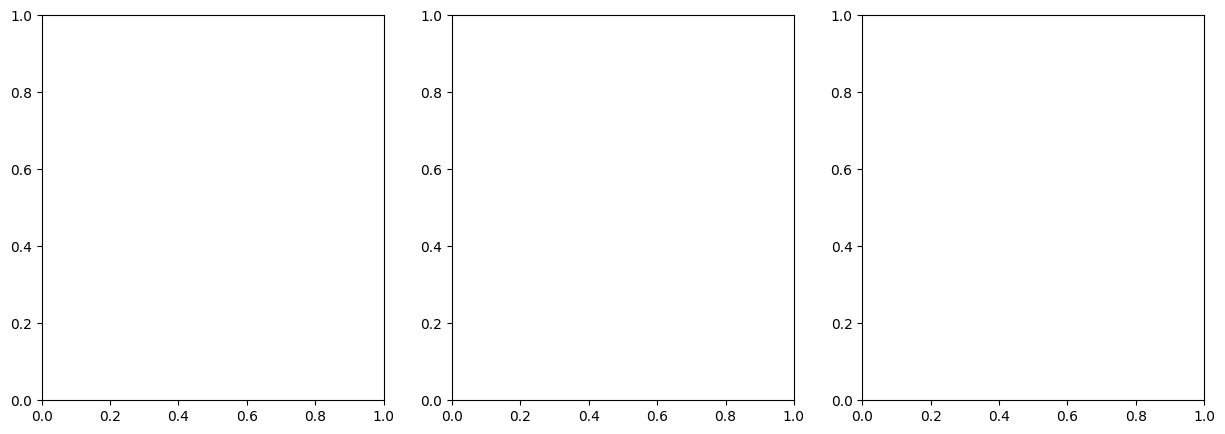

In [158]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

Z = {}

for k, (data, data_name) in enumerate(tqdm(training_conditions, desc='trainingCondition')):
    x_train = data[0]
    y_train = data[1]
    Z[data_name] = {}
    for j, (clf, clf_name) in enumerate(tqdm(clfs, leave=False, desc='Classifier')):
        pred = []
        for i in tqdm(range(n_iter), leave=False, desc='Iteration'):
            pred.append(get_decision_boundary(clone(clf), x_train, y_train, xx, yy)[0])
        Z[data_name][clf_name] = np.array(pred).mean(axis=0)


    # ax[j].contourf(xx, yy, Z, alpha=.03, cmap=cmap)
    # ax[j].scatter(x_train[:, 0], x_train[:, 1], c=y_train, edgecolors='k', cmap=cmap)
    # ax[j].scatter(*dataset.test_x.T, c='k', marker='x')
    # ax[j].set_xlabel('Feature 1')
    # ax[j].set_ylabel('Feature 2')
    # ax[j].set_title(clf_name + ' Decision Boundary')
    #

# plt.show()

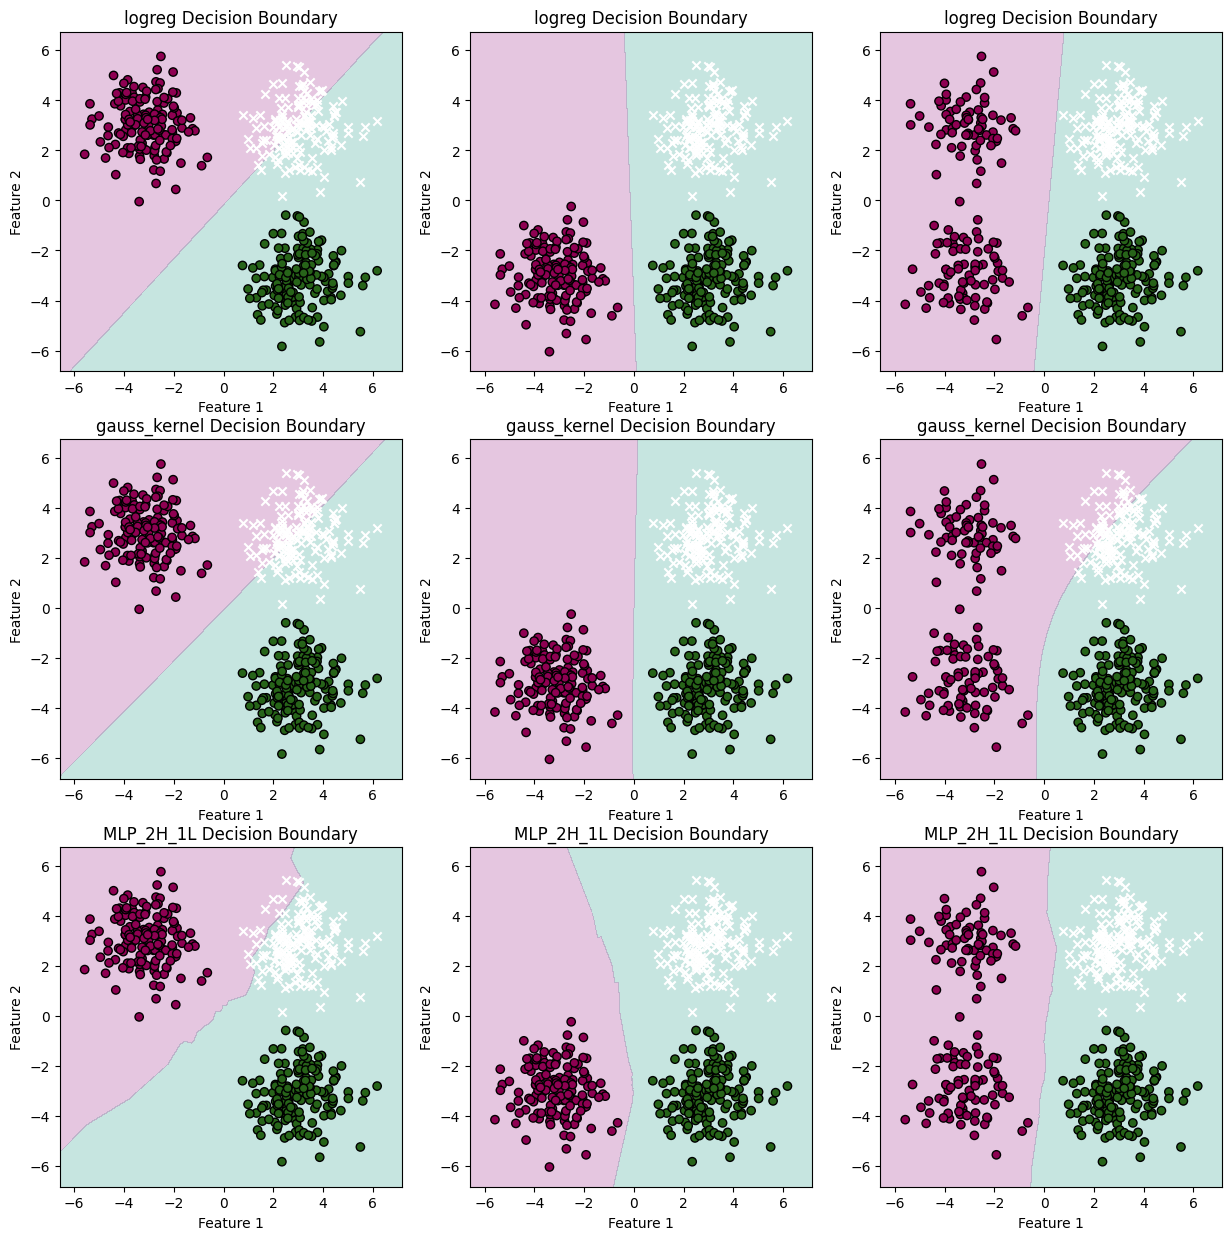

In [161]:
# plot all decision boundaries for each training condition and classifier
fig, ax = plt.subplots(3, 3, figsize=(15, 15))
for i, j in enumerate(Z.keys()):
    for k, l in enumerate(Z[j].keys()):
        ax[k, i].contourf(xx, yy, 1- Z[j][l], alpha=.3, levels = [0.0, 0.5, 1.1], colors = ['#44AA99', '#AA4499', '#AA4499'])
        #ax[k, i].contourf(xx, yy, Z[j][l], alpha=.3, vmax=1, vmin=0, cmap=cmap)
        ax[k, i].scatter(training_conditions[i][0][0][:, 0], training_conditions[i][0][0][:, 1], c=training_conditions[i][0][1], edgecolors='k', cmap=cmap)
        ax[k, i].scatter(*dataset.test_x.T, c='white', marker='x')
        ax[k, i].set_xlabel('Feature 1')
        ax[k, i].set_ylabel('Feature 2')
        ax[k, i].set_title(l + ' Decision Boundary')
        #ax[i, k].set_xlim(-1.5, 1.5)
        #ax[i, k].set_ylim(-1.5, 1.5)


plt.savefig('decision_boundaries.png')


In [160]:
np.unique(Z['ZeroShot']['MLP_5H_1L'])

KeyError: 'MLP_5H_1L'

In [ ]:
np.unique(Z['CueConflict']['MLP_5H_1L'])

In [ ]:
plt.contourf(Z['ZeroShot']['MLP_5H_1L'], vmin=0, vmax=1.1, cmap=cmap)
plt.savefig('test.png')

In [ ]:
plt.contourf(Z['ZeroShot']['MLP_5H_1L'], vmin=0, vmax=1, cmap=cmap)

In [ ]:
# train for zero shot
x_train, y_train = dataset.generate_data(pi_0=0, pi_1=0)

Z = []

for i in tqdm(range(n_iter), leave=False, desc='Iteration'):
    Z.append(get_decision_boundary(clone(clfs[-1][0]), x_train, y_train, xx, yy)[0])

In [ ]:
plt.contourf(xx, yy, np.mean(Z,axis=0), vmin=0, vmax=1, cmap=cmap)
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train, edgecolors='k', cmap=cmap)

In [162]:
# now compute the EvR (Exemplar vs Rule) score
